### Building simple RNN models

Populating the interactive namespace from numpy and matplotlib


/usr/local/lib/python3.9/site-packages/IPython/core/magics/pylab.py:159: UserWarning: pylab import has clobbered these variables: ['add']
`%matplotlib` prevents importing * from pylab and numpy
  warn("pylab import has clobbered these variables: %s"  % clobbered +


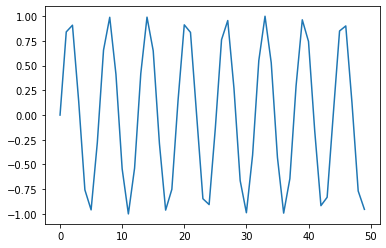

In [270]:
# Consider a sequence dataset in the form of a sine wave. Our task is to predict the next value in the sinewave sequence.
# More specifically, given a sequence of 50 numbers belonging to the sine wave, predict the 51st number of the series

# Data preparation
# The NN expects input data to being the following format:
# (number_of_observations) x (length_of_sequence) x (types_of_sequences)
# In our case, there is only 1 type of the sequence - the sine wave
# The output will be only one value, the 51st element of the sequence

%pylab inline
import math
import matplotlib.pyplot as plt
sin_wave=np.array([math.sin(x) for x in np.arange(200)])
plt.plot(sin_wave[:50])

In [272]:
# set the first 50 observations as our validation data
# train on the other 150 observations
# Define the parameters of RNN model
X = []
Y = []

seq_len = 50
num_records = len(sin_wave)-seq_len

for i in range(num_records-50):
    X.append(sin_wave[i:i+seq_len])
    Y.append(sin_wave[i+seq_len])

X= np.array(X)
X=np.expand_dims(X, axis=2)

Y=np.array(Y)
Y=np.expand_dims(Y, axis=1)

In [288]:
np.shape(X)

(100, 50, 1)

In [283]:
# Create RNN architecture
learning_rate = 0.001    
nepoch = 60              
T = 50                   # length of sequence
hidden_dim = 100         
output_dim = 1
# control for a possibility of an exploding gradient
bptt_truncate = 5
min_clip_value = -10
max_clip_value = 10

In [257]:
# create testing dataset
X_tst = []
Y_tst = []

for i in range(num_records - 50, num_records):
    X_tst.append(sin_wave[i:i+seq_len])
    Y_tst.append(sin_wave[i+seq_len])
    
X_tst = np.array(X_tst)
X_tst = np.expand_dims(X_tst, axis=2)

Y_tst = np.array(Y_tst)
Y_tst = np.expand_dims(Y_tst, axis=1)

In [259]:
# Define initial weights of the RNN
# U is the weight matrix for weights between input and hidden layers
# V is the weight matrix for weights between hidden and output layers
# W is the weight matrix for shared weights in the RNN layer (hidden layer)
U = np.random.uniform(0, 1, (hidden_dim, T))
W = np.random.uniform(0, 1, (hidden_dim, hidden_dim))
V = np.random.uniform(0, 1, (output_dim, hidden_dim))


In [260]:
# Define the activation function
def sigmoid(x):
    return 1 / (1+np.exp(-x))

###  Model training


In [261]:
# 1. Forward pass and MSE error calculation
for epoch in range(nepoch):
    # check loss on train
    loss = 0.0
    
    # do a forward pass to get prediction
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i]                    # get input, output values of each record
        prev_s = np.zeros((hidden_dim, 1))   # here, prev-s is the value of the previous activation of hidden layer; which is initialized as all zeroes
        for t in range(T):
            new_input = np.zeros(x.shape)    # we then do a forward pass for every timestep in the sequence
            new_input[t] = x[t]              # for this, we define a single input for that timestep
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

    # calculate error 
        loss_per_record = (y - mulv)**2 / 2
        loss += loss_per_record
    loss = loss / float(y.shape[0])

In [262]:
# Calculate loss on testing data
tst_loss = 0.0
for i in range(Y_tst.shape[0]):
    x, y = X_tst[i], Y_tst[i]
    prev_s = np.zeros((hidden_dim, 1))
    for t in range(T):
        new_input = np.zeros(x.shape)
        new_input[t] = x[t]
        mulu = np.dot(U, new_input)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    loss_per_record = (y - mulv)**2 / 2
    tst_loss += loss_per_record
tst_loss = tst_loss / float(y.shape[0])

print('Epoch: ', epoch + 1, ', Loss: ', loss, ', tst Loss: ', tst_loss)

Epoch:  100 , Loss:  [[121566.96215416]] , tst Loss:  [[60781.53952267]]


In [263]:
# Start actual training
# train model
for i in range(Y.shape[0]):
    x, y = X[i], Y[i] # individual time staps

    layers = []
    prev_s = np.zeros((hidden_dim, 1))
    dU = np.zeros(U.shape)# gradient initialization
    dV = np.zeros(V.shape)
    dW = np.zeros(W.shape)

    dU_t = np.zeros(U.shape)
    dV_t = np.zeros(V.shape)
    dW_t = np.zeros(W.shape)

    dU_i = np.zeros(U.shape)
    dW_i = np.zeros(W.shape)

    # forward pass
    for t in range(T):
        new_input = np.zeros(x.shape)
        new_input[t] = x[t]
        mulu = np.dot(U, new_input)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        layers.append({'s':s, 'prev_s':prev_s})
        prev_s = s

In [264]:
#Truncated error backpropagation

# derivative of pred
dmulv = (mulv - y)

# backward pass
for t in range(T):
    dV_t = np.dot(dmulv, np.transpose(layers[t]['s']))
    dsv = np.dot(np.transpose(V), dmulv)

    ds = dsv
    dadd = add * (1 - add) * ds

    dmulw = dadd * np.ones_like(mulw)

    dprev_s = np.dot(np.transpose(W), dmulw)


    for i in range(t-1, max(-1, t-bptt_truncate-1), -1):
        ds = dsv + dprev_s
        dadd = add * (1 - add) * ds

        dmulw = dadd * np.ones_like(mulw)
        dmulu = dadd * np.ones_like(mulu)

        dW_i = np.dot(W, layers[t]['prev_s'])
        dprev_s = np.dot(np.transpose(W), dmulw)

        new_input = np.zeros(x.shape)
        new_input[t] = x[t]
        dU_i = np.dot(U, new_input)
        dx = np.dot(np.transpose(U), dmulu)

        dU_t += dU_i
        dW_t += dW_i

    dV += dV_t
    dU += dU_t
    dW += dW_t

In [265]:
# weight update
# clamp gradients
if dU.max() > max_clip_value:
    dU[dU > max_clip_value] = max_clip_value
if dV.max() > max_clip_value:
    dV[dV > max_clip_value] = max_clip_value
if dW.max() > max_clip_value:
    dW[dW > max_clip_value] = max_clip_value


if dU.min() < min_clip_value:
    dU[dU < min_clip_value] = min_clip_value
if dV.min() < min_clip_value:
    dV[dV < min_clip_value] = min_clip_value
if dW.min() < min_clip_value:
    dW[dW < min_clip_value] = min_clip_value

# update
U -= learning_rate * dU
V -= learning_rate * dV
W -= learning_rate * dW

In [289]:
# Put all modules together

for epoch in range(nepoch):
    # check loss on train
    loss = 0.0
    # do a forward pass to get prediction
    for i in range(Y.shape[0]):
        x, y = X[i], Y[i] # get input, output values of each record
        prev_s = np.zeros((hidden_dim, 1))   # here, prev-s is the value of the previous activation of hidden layer; which is initialized as all zeroes
        for t in range(T):
            new_input = np.zeros(x.shape)    # we then do a forward pass for every timestep in the sequence
            new_input[t] = x[t]              # for this, we define a single input for that timestep
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

    # calculate error 
        loss_per_record = (y - mulv)**2 / 2
        loss += loss_per_record
    loss = loss / float(y.shape[0])
    #__________________________________
   
    # derivative of pred
    dmulv = (mulv - y)

    # backward pass
    for t in range(T):
        dV_t = np.dot(dmulv, np.transpose(layers[t]['s']))
        dsv = np.dot(np.transpose(V), dmulv)

        ds = dsv
        dadd = add * (1 - add) * ds

        dmulw = dadd * np.ones_like(mulw)

        dprev_s = np.dot(np.transpose(W), dmulw)


        for i in range(t-1, max(-1, t-bptt_truncate-1), -1):
            ds = dsv + dprev_s
            dadd = add * (1 - add) * ds

            dmulw = dadd * np.ones_like(mulw)
            dmulu = dadd * np.ones_like(mulu)

            dW_i = np.dot(W, layers[t]['prev_s'])
            dprev_s = np.dot(np.transpose(W), dmulw)

            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            dU_i = np.dot(U, new_input)
            dx = np.dot(np.transpose(U), dmulu)

            dU_t += dU_i
            dW_t += dW_i

        dV += dV_t
        dU += dU_t
        dW += dW_t
    #___________________________________________
    # weight update
    # clamp gradients
    if dU.max() > max_clip_value:
        dU[dU > max_clip_value] = max_clip_value
    if dV.max() > max_clip_value:
        dV[dV > max_clip_value] = max_clip_value
    if dW.max() > max_clip_value:
        dW[dW > max_clip_value] = max_clip_value


    if dU.min() < min_clip_value:
        dU[dU < min_clip_value] = min_clip_value
    if dV.min() < min_clip_value:
        dV[dV < min_clip_value] = min_clip_value
    if dW.min() < min_clip_value:
        dW[dW < min_clip_value] = min_clip_value

    # update
    U -= learning_rate * dU
    V -= learning_rate * dV
    W -= learning_rate * dW
    #   loss on testing data    
#___________________________________________
    tst_loss = 0.0
    for i in range(Y_tst.shape[0]):
        x, y = X_tst[i], Y_tst[i]
        prev_s = np.zeros((hidden_dim, 1))
        for t in range(T):
            new_input = np.zeros(x.shape)
            new_input[t] = x[t]
            mulu = np.dot(U, new_input)
            mulw = np.dot(W, prev_s)
            add = mulw + mulu
            s = sigmoid(add)
            mulv = np.dot(V, s)
            prev_s = s

        loss_per_record = (y - mulv)**2 / 2
        tst_loss += loss_per_record
    tst_loss = tst_loss / float(y.shape[0])
#_____________________________________________
   
#___________________________________________
    print('Epoch: ', epoch + 1, ', Loss: ', loss, ', tst Loss: ', tst_loss)    

Epoch:  1 , Loss:  [[4928.45813567]] , tst Loss:  [[1994.37995754]]
Epoch:  2 , Loss:  [[3988.1521033]] , tst Loss:  [[1574.18836399]]
Epoch:  3 , Loss:  [[3147.84607101]] , tst Loss:  [[1203.99677055]]
Epoch:  4 , Loss:  [[2407.54003895]] , tst Loss:  [[883.8051774]]
Epoch:  5 , Loss:  [[1767.23400745]] , tst Loss:  [[613.61358494]]
Epoch:  6 , Loss:  [[1226.92797736]] , tst Loss:  [[393.42199409]]
Epoch:  7 , Loss:  [[786.62195047]] , tst Loss:  [[223.23040654]]
Epoch:  8 , Loss:  [[446.31593019]] , tst Loss:  [[103.03882445]]
Epoch:  9 , Loss:  [[206.00992081]] , tst Loss:  [[32.84724573]]
Epoch:  10 , Loss:  [[65.70391818]] , tst Loss:  [[14.39134846]]
Epoch:  11 , Loss:  [[28.84021731]] , tst Loss:  [[53.41621398]]
Epoch:  12 , Loss:  [[106.81279368]] , tst Loss:  [[28.31817217]]
Epoch:  13 , Loss:  [[56.65398876]] , tst Loss:  [[49.43669779]]
Epoch:  14 , Loss:  [[98.85868261]] , tst Loss:  [[17.89985836]]
Epoch:  15 , Loss:  [[35.84278137]] , tst Loss:  [[66.3087191]]
Epoch:  16

In [290]:
# Get predictions on training dataset
preds = []
for i in range(Y.shape[0]):
    x, y = X[i], Y[i]
    prev_s = np.zeros((hidden_dim, 1))
    # Forward pass
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

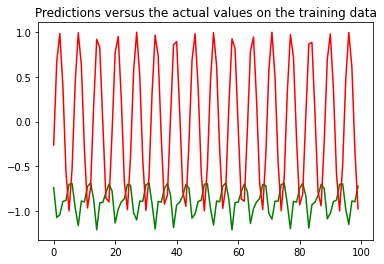

In [291]:
plt.plot(preds[:,0,0],'g')
plt.plot(Y[:,0],'r')
plt.title("Predictions versus the actual values on the training data")
plt.show()

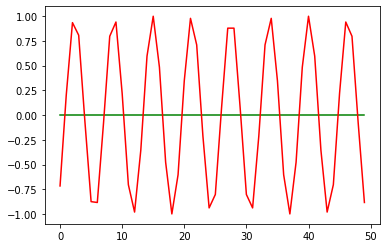

In [269]:
# Check if our model is not an overfit
preds = []
for i in range(Y_tst.shape[0]):
    x, y = X_tst[i], Y_tst[i]
    prev_s = np.zeros((hidden_dim, 1))
    # For each time step...
    for t in range(T):
        mulu = np.dot(U, x)
        mulw = np.dot(W, prev_s)
        add = mulw + mulu
        s = sigmoid(add)
        mulv = np.dot(V, s)
        prev_s = s

    preds.append(mulv)
    
preds = np.array(preds)

plt.plot(preds[:, 0, 0], 'g')
plt.plot(Y_tst[:, 0], 'r')
plt.show()

###  Task 1

In [ ]:
# 1. Using the same sine wave sequence, experiment with the RNN parameter setup and build your own RNN model
# 2. Has you model been learning during training process? How can you tell?
# 3. Does your model improve the prediction result obtained in class? Whether it improves the result or not, plot 
# the graphs of prediction and actual curves using testing dataset and discuss your result.
# 4. How do the gradient constraints influence training? Does increasing lower and upper boundaries in absolute value help RNN learn? 
# 5. What are the main neuron operations that take place in the feedforward pass of the RNN network?